In [34]:
import statsmodels.tsa.api as smt
class ARMA(Dataset):

    def __init__(self, p: Sequence[float], q: Sequence[float], seed: int = None,
                 n_series: int = 200, datapoints: int = 100):
        """
        Pytorch Dataset to sample a given ARMA process.
        
        y = ARMA(p,q)
        :param p: AR parameters
        :param q: MA parameters
        :param seed: random seed
        :param n_series: number of ARMA samples in your dataset
        :param datapoints: length of each sample
        """
        self.p = p
        self.q = q
        self.n_series = n_series
        self.datapoints = datapoints
        self.seed = seed
        self.dataset = self._generate_ARMA()

    def __len__(self):
        return self.n_series

    def __getitem__(self, idx):
        return self.dataset[idx]

    def _generate_ARMA(self):

        if self.seed is not None:
            np.random.seed(self.seed)

        ar = np.array(self.p)
        ma = np.array(self.q)
        ar = np.r_[1, -ar]
        ma = np.r_[1, ma]
        burn = int(self.datapoints / 10)

        dataset = []

        for i in range(self.n_series):
            arma = smt.arma_generate_sample(ar=ar, ma=ma, nsample=self.datapoints, burnin=burn)
            dataset.append(arma)

        return np.array(dataset)

In [35]:
from typing import Sequence

from torch.utils.data import Dataset
import numpy as np


class Sines(Dataset):

    def __init__(self, frequency_range: Sequence[float], amplitude_range: Sequence[float],
                 n_series: int = 200, datapoints: int = 100, seed: int = None):
        """
        Pytorch Dataset to produce sines.
        y = A * sin(B * x)
        :param frequency_range: range of A
        :param amplitude_range: range of B
        :param n_series: number of sines in your dataset
        :param datapoints: length of each sample
        :param seed: random seed
        """
        self.n_series = n_series
        self.datapoints = datapoints
        self.seed = seed
        self.frequency_range = frequency_range
        self.amplitude_range = amplitude_range
        self.dataset = self._generate_sines()

    def __len__(self):
        return self.n_series

    def __getitem__(self, idx):
        return self.dataset[idx]

    def _generate_sines(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        x = np.linspace(start=0, stop=2 * np.pi, num=self.datapoints)
        low_freq, up_freq = self.frequency_range[0], self.frequency_range[1]
        low_amp, up_amp = self.amplitude_range[0], self.amplitude_range[1]

        freq_vector = (up_freq - low_freq) * np.random.rand(self.n_series, 1) + low_freq
        ampl_vector = (up_amp - low_amp) * np.random.rand(self.n_series, 1) + low_amp

        return ampl_vector * np.sin(freq_vector * x)

In [36]:
from torch import nn
from torch.nn.utils import spectral_norm


class AddDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)


class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)


def create_generator_architecture():
    return nn.Sequential(nn.Linear(50, 100),
                         nn.LeakyReLU(0.2, inplace=True),
                         AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.Upsample(200),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Upsample(400),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Upsample(800),

                         spectral_norm(nn.Conv1d(32, 1, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),

                         SqueezeDimension(),
                         nn.Linear(800, 100)
                         )


def create_critic_architecture():
    return nn.Sequential(AddDimension(),
                         spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.MaxPool1d(2),
                         
                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.MaxPool1d(2),

                         spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                         nn.LeakyReLU(0.2, inplace=True),
                         nn.Flatten(),

                         nn.Linear(800, 50),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(50, 15),
                         nn.LeakyReLU(0.2, inplace=True),

                         nn.Linear(15, 1)
                         )


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = create_generator_architecture()

    def forward(self, input):
        return self.main(input)


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = create_critic_architecture()

    def forward(self, input):
        return self.main(input)

In [37]:
import argparse
import os


import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from math import pi


class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=200, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, real_data):

        batch_size = real_data.size()[0]
        noise_shape = (batch_size, self.NOISE_LENGTH)
        generated_data = self.sample_generator(noise_shape)

        real_data = Variable(real_data)

        if self.use_cuda:
            real_data = real_data.cuda()

        # Pass data through the Critic
        c_real = self.c(real_data)
        c_generated = self.c(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(real_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        batch_size = data.size()[0]
        latent_shape = (batch_size, self.NOISE_LENGTH)

        generated_data = self.sample_generator(latent_shape)

        # Calculate loss and optimize
        d_generated = self.c(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):

        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch, writer):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data.float())
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

            if i % self.print_every == 0:
                global_step = i + epoch * len(data_loader.dataset)
                writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
                writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
                writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

                if self.num_steps > self.critic_iterations:
                    writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, epochs, plot_training_samples=True, checkpoint=None, writer=None):

        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
        # Define noise_shape
        noise_shape = (1, self.NOISE_LENGTH)
        
        if plot_training_samples:
            # Fix latents to see how series generation improves during training
            fixed_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()

        for epoch in tqdm(range(epochs)):

            # Sample a different region of the latent distribution to check for mode collapse
            dynamic_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1, writer)

#             # Save checkpoint
#             if epoch % self.checkpoint_frequency == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'd_state_dict': self.c.state_dict(),
#                     'g_state_dict': self.g.state_dict(),
#                     'd_opt_state_dict': self.c_opt.state_dict(),
#                     'g_opt_state_dict': self.g_opt.state_dict(),
#                 }, 'checkpoints/epoch_{}.pkl'.format(epoch))

            if plot_training_samples and (epoch % self.print_every == 0):
                self.g.eval()
                # Generate fake data using both fixed and dynamic latents
                fake_data_fixed_latents = self.g(fixed_latents).cpu().data
                fake_data_dynamic_latents = self.g(dynamic_latents).cpu().data

                plt.figure()
                plt.plot(fake_data_fixed_latents.numpy()[0].T)
                plt.show()
                #plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
                plt.close()

                plt.figure()
                plt.plot(fake_data_dynamic_latents.numpy()[0].T)
                #plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
                plt.show()
                plt.close()
                self.g.train()

    def sample_generator(self, latent_shape):
        latent_samples = Variable(self.sample_latent(latent_shape))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()

        return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


def run_GAN():


    batch_size = 16
    epochs = 5000
    log_name = 'tensorboard_log_name'
    checkpoint = None
    

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Critic()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)

    # Create Dataloader
    dataset = ARMA(p = .7, q = .2, seed=42, n_series=200)
    dataloader = DataLoader(dataset, batch_size)

    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
    tb_logdir = os.path.join('..', 'tensorboard', log_name)
    writer = SummaryWriter(tb_logdir)

    trainer.train(dataloader, epochs=epochs, plot_training_samples=True, checkpoint=checkpoint, writer=writer)





  0%|          | 0/5000 [00:00<?, ?it/s]

Training is about to start...


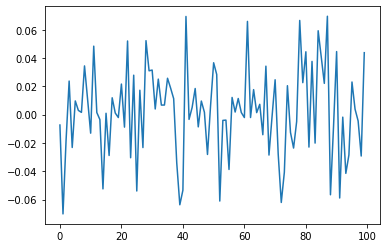

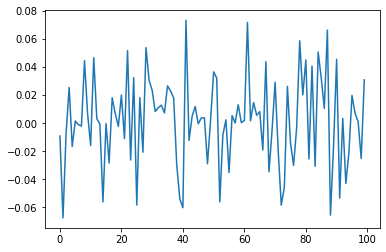





  0%|          | 1/5000 [00:00<1:17:57,  1.07it/s]



  0%|          | 2/5000 [00:01<1:12:34,  1.15it/s]



  0%|          | 3/5000 [00:02<1:07:49,  1.23it/s]



  0%|          | 4/5000 [00:03<1:05:05,  1.28it/s]



  0%|          | 5/5000 [00:03<1:03:32,  1.31it/s]



  0%|          | 6/5000 [00:04<1:02:11,  1.34it/s]



  0%|          | 7/5000 [00:05<1:01:54,  1.34it/s]



  0%|          | 8/5000 [00:05<1:00:32,  1.37it/s]



  0%|          | 9/5000 [00:06<59:54,  1.39it/s]  



  0%|          | 10/5000 [00:07<59:53,  1.39it/s]



  0%|          | 11/5000 [00:08<59:43,  1.39it/s]



  0%|          | 12/5000 [00:08<1:00:23,  1.38it/s]



  0%|          | 13/5000 [00:09<1:00:47,  1.37it/s]



  0%|          | 14/5000 [00:10<1:00:19,  1.38it/s]



  0%|          | 15/5000 [00:10<59:48,  1.39it/s]  



  0%|          | 16/5000 [00:11<1:00:04,  1.38it/s]



  0%|          | 17/5000 [00:12<1:00:45,  1.37it/s]



  0%|          | 18/5000 [00:13<59:46,  1.39it/s]  



  0%|          | 19

  2%|▏         | 124/5000 [01:31<1:01:46,  1.32it/s]



  2%|▎         | 125/5000 [01:31<1:02:06,  1.31it/s]



  3%|▎         | 126/5000 [01:32<1:01:05,  1.33it/s]



  3%|▎         | 127/5000 [01:33<1:01:38,  1.32it/s]



  3%|▎         | 128/5000 [01:34<1:00:55,  1.33it/s]



  3%|▎         | 129/5000 [01:34<1:00:50,  1.33it/s]



  3%|▎         | 130/5000 [01:35<1:00:45,  1.34it/s]



  3%|▎         | 131/5000 [01:36<1:00:09,  1.35it/s]



  3%|▎         | 132/5000 [01:37<1:01:13,  1.33it/s]



  3%|▎         | 133/5000 [01:37<1:01:25,  1.32it/s]



  3%|▎         | 134/5000 [01:38<1:02:10,  1.30it/s]



  3%|▎         | 135/5000 [01:39<1:02:05,  1.31it/s]



  3%|▎         | 136/5000 [01:40<1:00:58,  1.33it/s]



  3%|▎         | 137/5000 [01:41<1:01:27,  1.32it/s]



  3%|▎         | 138/5000 [01:41<1:00:22,  1.34it/s]



  3%|▎         | 139/5000 [01:42<1:00:19,  1.34it/s]



  3%|▎         | 140/5000 [01:43<1:00:56,  1.33it/s]



  3%|▎         | 141/5000 [01:44<1:00:44,  1.33i

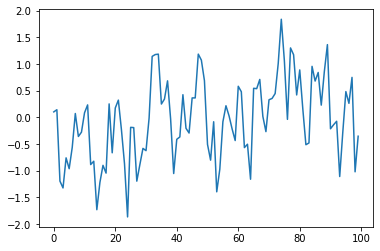

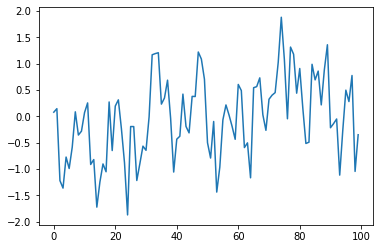





  4%|▍         | 201/5000 [02:28<1:04:28,  1.24it/s]



  4%|▍         | 202/5000 [02:29<1:03:40,  1.26it/s]



  4%|▍         | 203/5000 [02:30<1:02:12,  1.29it/s]



  4%|▍         | 204/5000 [02:31<1:01:42,  1.30it/s]



  4%|▍         | 205/5000 [02:31<1:01:18,  1.30it/s]



  4%|▍         | 206/5000 [02:32<1:00:25,  1.32it/s]



  4%|▍         | 207/5000 [02:33<1:00:24,  1.32it/s]



  4%|▍         | 208/5000 [02:34<59:42,  1.34it/s]  



  4%|▍         | 209/5000 [02:34<1:00:01,  1.33it/s]



  4%|▍         | 210/5000 [02:35<1:00:11,  1.33it/s]



  4%|▍         | 211/5000 [02:36<59:16,  1.35it/s]  



  4%|▍         | 212/5000 [02:37<59:37,  1.34it/s]



  4%|▍         | 213/5000 [02:37<59:30,  1.34it/s]



  4%|▍         | 214/5000 [02:38<59:53,  1.33it/s]



  4%|▍         | 215/5000 [02:39<1:00:02,  1.33it/s]



  4%|▍         | 216/5000 [02:40<59:42,  1.34it/s]  



  4%|▍         | 217/5000 [02:40<1:00:00,  1.33it/s]



  4%|▍         | 218/5000 [02:41<59:14,  1.35it/s]

  6%|▋         | 322/5000 [04:03<1:01:09,  1.27it/s]



  6%|▋         | 323/5000 [04:03<1:00:55,  1.28it/s]



  6%|▋         | 324/5000 [04:04<1:01:03,  1.28it/s]



  6%|▋         | 325/5000 [04:05<1:00:33,  1.29it/s]



  7%|▋         | 326/5000 [04:06<59:36,  1.31it/s]  



  7%|▋         | 327/5000 [04:06<59:39,  1.31it/s]



  7%|▋         | 328/5000 [04:07<59:30,  1.31it/s]



  7%|▋         | 329/5000 [04:08<1:00:08,  1.29it/s]



  7%|▋         | 330/5000 [04:09<1:00:45,  1.28it/s]



  7%|▋         | 331/5000 [04:10<1:00:21,  1.29it/s]



  7%|▋         | 332/5000 [04:10<1:00:38,  1.28it/s]



  7%|▋         | 333/5000 [04:11<1:00:05,  1.29it/s]



  7%|▋         | 334/5000 [04:12<1:00:22,  1.29it/s]



  7%|▋         | 335/5000 [04:13<1:00:07,  1.29it/s]



  7%|▋         | 336/5000 [04:13<1:00:14,  1.29it/s]



  7%|▋         | 337/5000 [04:14<1:00:07,  1.29it/s]



  7%|▋         | 338/5000 [04:15<59:26,  1.31it/s]  



  7%|▋         | 339/5000 [04:16<59:36,  1.30it/s]



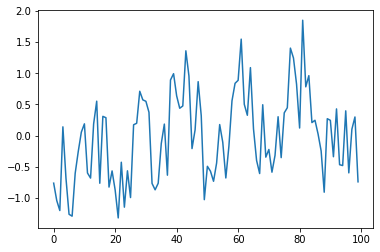

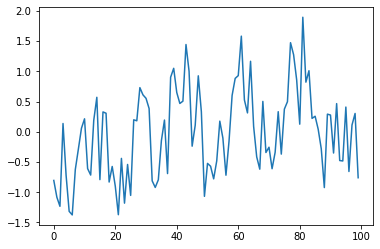





  8%|▊         | 401/5000 [05:02<1:02:26,  1.23it/s]



  8%|▊         | 402/5000 [05:03<1:01:05,  1.25it/s]



  8%|▊         | 403/5000 [05:04<59:25,  1.29it/s]  



  8%|▊         | 404/5000 [05:05<58:53,  1.30it/s]



  8%|▊         | 405/5000 [05:05<58:23,  1.31it/s]



  8%|▊         | 406/5000 [05:06<57:35,  1.33it/s]



  8%|▊         | 407/5000 [05:07<57:45,  1.33it/s]



  8%|▊         | 408/5000 [05:08<57:07,  1.34it/s]



  8%|▊         | 409/5000 [05:08<57:55,  1.32it/s]



  8%|▊         | 410/5000 [05:09<57:56,  1.32it/s]



  8%|▊         | 411/5000 [05:10<57:28,  1.33it/s]



  8%|▊         | 412/5000 [05:11<58:07,  1.32it/s]



  8%|▊         | 413/5000 [05:11<57:54,  1.32it/s]



  8%|▊         | 414/5000 [05:12<58:09,  1.31it/s]



  8%|▊         | 415/5000 [05:13<58:28,  1.31it/s]



  8%|▊         | 416/5000 [05:14<58:40,  1.30it/s]



  8%|▊         | 417/5000 [05:14<59:47,  1.28it/s]



  8%|▊         | 418/5000 [05:15<1:01:52,  1.23it/s]



  8%|▊         |

 10%|█         | 524/5000 [06:37<56:03,  1.33it/s]



 10%|█         | 525/5000 [06:38<55:53,  1.33it/s]



 11%|█         | 526/5000 [06:39<55:36,  1.34it/s]



 11%|█         | 527/5000 [06:39<56:21,  1.32it/s]



 11%|█         | 528/5000 [06:40<55:46,  1.34it/s]



 11%|█         | 529/5000 [06:41<56:20,  1.32it/s]



 11%|█         | 530/5000 [06:42<56:04,  1.33it/s]



 11%|█         | 531/5000 [06:42<55:29,  1.34it/s]



 11%|█         | 532/5000 [06:43<56:36,  1.32it/s]



 11%|█         | 533/5000 [06:44<56:42,  1.31it/s]



 11%|█         | 534/5000 [06:45<56:35,  1.32it/s]



 11%|█         | 535/5000 [06:46<56:12,  1.32it/s]



 11%|█         | 536/5000 [06:46<55:26,  1.34it/s]



 11%|█         | 537/5000 [06:47<55:57,  1.33it/s]



 11%|█         | 538/5000 [06:48<55:45,  1.33it/s]



 11%|█         | 539/5000 [06:49<56:19,  1.32it/s]



 11%|█         | 540/5000 [06:49<56:06,  1.32it/s]



 11%|█         | 541/5000 [06:50<55:53,  1.33it/s]



 11%|█         | 542/5000 [0

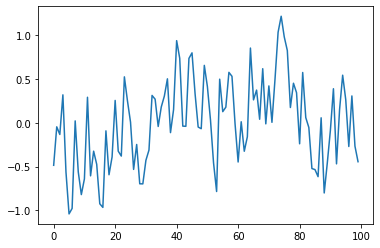

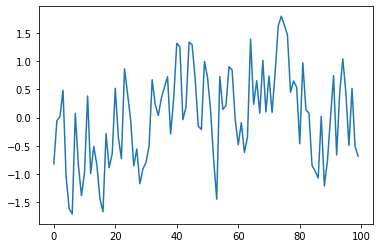





 12%|█▏        | 601/5000 [07:37<1:00:28,  1.21it/s]



 12%|█▏        | 602/5000 [07:37<59:07,  1.24it/s]  



 12%|█▏        | 603/5000 [07:38<57:34,  1.27it/s]



 12%|█▏        | 604/5000 [07:39<57:03,  1.28it/s]



 12%|█▏        | 605/5000 [07:40<56:43,  1.29it/s]



 12%|█▏        | 606/5000 [07:40<56:00,  1.31it/s]



 12%|█▏        | 607/5000 [07:41<55:48,  1.31it/s]



 12%|█▏        | 608/5000 [07:42<55:07,  1.33it/s]



 12%|█▏        | 609/5000 [07:43<55:37,  1.32it/s]



 12%|█▏        | 610/5000 [07:43<55:58,  1.31it/s]



 12%|█▏        | 611/5000 [07:44<55:30,  1.32it/s]



 12%|█▏        | 612/5000 [07:45<56:11,  1.30it/s]



 12%|█▏        | 613/5000 [07:46<55:25,  1.32it/s]



 12%|█▏        | 614/5000 [07:46<56:23,  1.30it/s]



 12%|█▏        | 615/5000 [07:47<58:04,  1.26it/s]



 12%|█▏        | 616/5000 [07:48<57:28,  1.27it/s]



 12%|█▏        | 617/5000 [07:49<58:11,  1.26it/s]



 12%|█▏        | 618/5000 [07:50<57:48,  1.26it/s]



 12%|█▏        | 619

 14%|█▍        | 725/5000 [09:12<54:06,  1.32it/s]



 15%|█▍        | 726/5000 [09:12<53:36,  1.33it/s]



 15%|█▍        | 727/5000 [09:13<53:56,  1.32it/s]



 15%|█▍        | 728/5000 [09:14<53:25,  1.33it/s]



 15%|█▍        | 729/5000 [09:15<53:42,  1.33it/s]



 15%|█▍        | 730/5000 [09:15<53:46,  1.32it/s]



 15%|█▍        | 731/5000 [09:16<53:19,  1.33it/s]



 15%|█▍        | 732/5000 [09:17<53:41,  1.32it/s]



 15%|█▍        | 733/5000 [09:18<53:18,  1.33it/s]



 15%|█▍        | 734/5000 [09:18<53:37,  1.33it/s]



 15%|█▍        | 735/5000 [09:19<53:42,  1.32it/s]



 15%|█▍        | 736/5000 [09:20<53:13,  1.34it/s]



 15%|█▍        | 737/5000 [09:21<53:11,  1.34it/s]



 15%|█▍        | 738/5000 [09:21<52:31,  1.35it/s]



 15%|█▍        | 739/5000 [09:22<53:14,  1.33it/s]



 15%|█▍        | 740/5000 [09:23<53:05,  1.34it/s]



 15%|█▍        | 741/5000 [09:24<52:22,  1.36it/s]



 15%|█▍        | 742/5000 [09:24<52:27,  1.35it/s]



 15%|█▍        | 743/5000 [0

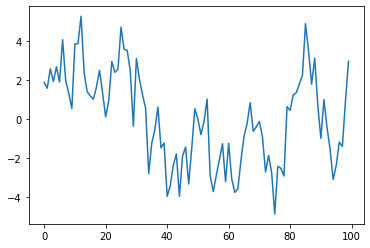

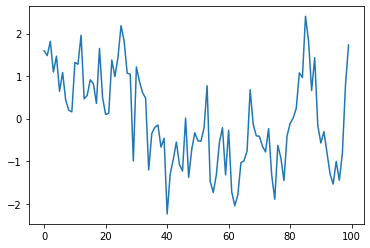





 16%|█▌        | 801/5000 [10:10<58:14,  1.20it/s]



 16%|█▌        | 802/5000 [10:11<56:44,  1.23it/s]



 16%|█▌        | 803/5000 [10:12<55:22,  1.26it/s]



 16%|█▌        | 804/5000 [10:13<54:38,  1.28it/s]



 16%|█▌        | 805/5000 [10:13<53:57,  1.30it/s]



 16%|█▌        | 806/5000 [10:14<53:15,  1.31it/s]



 16%|█▌        | 807/5000 [10:15<53:19,  1.31it/s]



 16%|█▌        | 808/5000 [10:16<53:06,  1.32it/s]



 16%|█▌        | 809/5000 [10:16<53:44,  1.30it/s]



 16%|█▌        | 810/5000 [10:17<53:55,  1.30it/s]



 16%|█▌        | 811/5000 [10:18<53:06,  1.31it/s]



 16%|█▌        | 812/5000 [10:19<53:30,  1.30it/s]



 16%|█▋        | 813/5000 [10:19<53:03,  1.32it/s]



 16%|█▋        | 814/5000 [10:20<53:30,  1.30it/s]



 16%|█▋        | 815/5000 [10:21<53:33,  1.30it/s]



 16%|█▋        | 816/5000 [10:22<53:07,  1.31it/s]



 16%|█▋        | 817/5000 [10:23<53:57,  1.29it/s]



 16%|█▋        | 818/5000 [10:23<53:33,  1.30it/s]



 16%|█▋        | 819/500

 18%|█▊        | 925/5000 [11:47<53:04,  1.28it/s]



 19%|█▊        | 926/5000 [11:47<52:51,  1.28it/s]



 19%|█▊        | 927/5000 [11:48<52:46,  1.29it/s]



 19%|█▊        | 928/5000 [11:49<52:07,  1.30it/s]



 19%|█▊        | 929/5000 [11:50<53:02,  1.28it/s]



 19%|█▊        | 930/5000 [11:50<53:00,  1.28it/s]



 19%|█▊        | 931/5000 [11:51<52:34,  1.29it/s]



 19%|█▊        | 932/5000 [11:52<53:18,  1.27it/s]



 19%|█▊        | 933/5000 [11:53<53:18,  1.27it/s]



 19%|█▊        | 934/5000 [11:54<53:08,  1.28it/s]



 19%|█▊        | 935/5000 [11:54<53:03,  1.28it/s]



 19%|█▊        | 936/5000 [11:55<52:21,  1.29it/s]



 19%|█▊        | 937/5000 [11:56<52:29,  1.29it/s]



 19%|█▉        | 938/5000 [11:57<52:30,  1.29it/s]



 19%|█▉        | 939/5000 [11:57<53:18,  1.27it/s]



 19%|█▉        | 940/5000 [11:58<53:30,  1.26it/s]



 19%|█▉        | 941/5000 [11:59<53:16,  1.27it/s]



 19%|█▉        | 942/5000 [12:00<53:38,  1.26it/s]



 19%|█▉        | 943/5000 [1

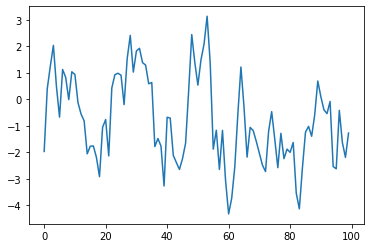

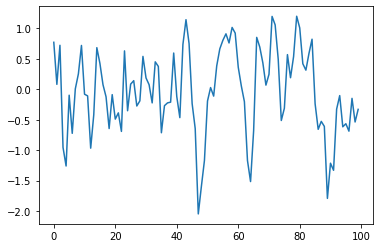





 20%|██        | 1001/5000 [12:47<58:51,  1.13it/s]



 20%|██        | 1002/5000 [12:47<56:34,  1.18it/s]



 20%|██        | 1003/5000 [12:48<54:21,  1.23it/s]



 20%|██        | 1004/5000 [12:49<53:22,  1.25it/s]



 20%|██        | 1005/5000 [12:50<52:04,  1.28it/s]



 20%|██        | 1006/5000 [12:50<50:45,  1.31it/s]



 20%|██        | 1007/5000 [12:51<50:32,  1.32it/s]



 20%|██        | 1008/5000 [12:52<49:47,  1.34it/s]



 20%|██        | 1009/5000 [12:53<49:49,  1.34it/s]



 20%|██        | 1010/5000 [12:53<49:38,  1.34it/s]



 20%|██        | 1011/5000 [12:54<49:06,  1.35it/s]



 20%|██        | 1012/5000 [12:55<49:23,  1.35it/s]



 20%|██        | 1013/5000 [12:56<48:53,  1.36it/s]



 20%|██        | 1014/5000 [12:56<49:09,  1.35it/s]



 20%|██        | 1015/5000 [12:57<49:13,  1.35it/s]



 20%|██        | 1016/5000 [12:58<48:41,  1.36it/s]



 20%|██        | 1017/5000 [12:58<48:58,  1.36it/s]



 20%|██        | 1018/5000 [12:59<48:33,  1.37it/s]



 20%|█

 22%|██▏       | 1123/5000 [14:17<47:20,  1.36it/s]



 22%|██▏       | 1124/5000 [14:18<47:37,  1.36it/s]



 22%|██▎       | 1125/5000 [14:19<47:40,  1.35it/s]



 23%|██▎       | 1126/5000 [14:19<47:19,  1.36it/s]



 23%|██▎       | 1127/5000 [14:20<47:31,  1.36it/s]



 23%|██▎       | 1128/5000 [14:21<47:16,  1.37it/s]



 23%|██▎       | 1129/5000 [14:22<47:32,  1.36it/s]



 23%|██▎       | 1130/5000 [14:22<47:37,  1.35it/s]



 23%|██▎       | 1131/5000 [14:23<47:14,  1.36it/s]



 23%|██▎       | 1132/5000 [14:24<47:33,  1.36it/s]



 23%|██▎       | 1133/5000 [14:24<47:10,  1.37it/s]



 23%|██▎       | 1134/5000 [14:25<47:25,  1.36it/s]



 23%|██▎       | 1135/5000 [14:26<47:30,  1.36it/s]



 23%|██▎       | 1136/5000 [14:27<47:06,  1.37it/s]



 23%|██▎       | 1137/5000 [14:27<47:29,  1.36it/s]



 23%|██▎       | 1138/5000 [14:28<47:02,  1.37it/s]



 23%|██▎       | 1139/5000 [14:29<47:39,  1.35it/s]



 23%|██▎       | 1140/5000 [14:30<48:04,  1.34it/s]



 23%|██▎  

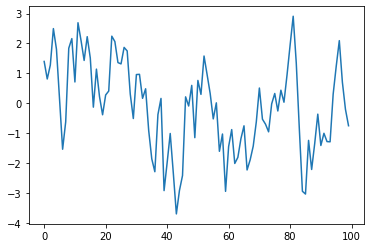

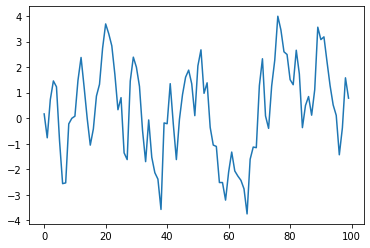





 24%|██▍       | 1201/5000 [15:16<51:04,  1.24it/s]



 24%|██▍       | 1202/5000 [15:17<49:50,  1.27it/s]



 24%|██▍       | 1203/5000 [15:17<48:35,  1.30it/s]



 24%|██▍       | 1204/5000 [15:18<48:11,  1.31it/s]



 24%|██▍       | 1205/5000 [15:19<48:31,  1.30it/s]



 24%|██▍       | 1206/5000 [15:19<47:23,  1.33it/s]



 24%|██▍       | 1207/5000 [15:20<47:08,  1.34it/s]



 24%|██▍       | 1208/5000 [15:21<46:24,  1.36it/s]



 24%|██▍       | 1209/5000 [15:22<46:24,  1.36it/s]



 24%|██▍       | 1210/5000 [15:22<46:12,  1.37it/s]



 24%|██▍       | 1211/5000 [15:23<45:45,  1.38it/s]



 24%|██▍       | 1212/5000 [15:24<45:59,  1.37it/s]



 24%|██▍       | 1213/5000 [15:25<45:33,  1.39it/s]



 24%|██▍       | 1214/5000 [15:25<45:52,  1.38it/s]



 24%|██▍       | 1215/5000 [15:26<45:50,  1.38it/s]



 24%|██▍       | 1216/5000 [15:27<45:30,  1.39it/s]



 24%|██▍       | 1217/5000 [15:27<45:48,  1.38it/s]



 24%|██▍       | 1218/5000 [15:28<45:29,  1.39it/s]



 24%|█

 26%|██▋       | 1323/5000 [16:46<45:42,  1.34it/s]



 26%|██▋       | 1324/5000 [16:47<46:01,  1.33it/s]



 26%|██▋       | 1325/5000 [16:48<46:03,  1.33it/s]



 27%|██▋       | 1326/5000 [16:49<45:39,  1.34it/s]



 27%|██▋       | 1327/5000 [16:49<46:00,  1.33it/s]



 27%|██▋       | 1328/5000 [16:50<45:37,  1.34it/s]



 27%|██▋       | 1329/5000 [16:51<45:54,  1.33it/s]



 27%|██▋       | 1330/5000 [16:52<46:03,  1.33it/s]



 27%|██▋       | 1331/5000 [16:52<45:38,  1.34it/s]



 27%|██▋       | 1332/5000 [16:53<45:58,  1.33it/s]



 27%|██▋       | 1333/5000 [16:54<45:39,  1.34it/s]



 27%|██▋       | 1334/5000 [16:55<45:55,  1.33it/s]



 27%|██▋       | 1335/5000 [16:55<45:57,  1.33it/s]



 27%|██▋       | 1336/5000 [16:56<45:31,  1.34it/s]



 27%|██▋       | 1337/5000 [16:57<45:51,  1.33it/s]



 27%|██▋       | 1338/5000 [16:58<45:30,  1.34it/s]



 27%|██▋       | 1339/5000 [16:58<45:51,  1.33it/s]



 27%|██▋       | 1340/5000 [16:59<45:50,  1.33it/s]



 27%|██▋  

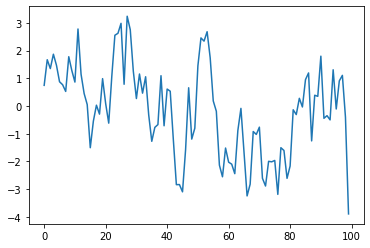

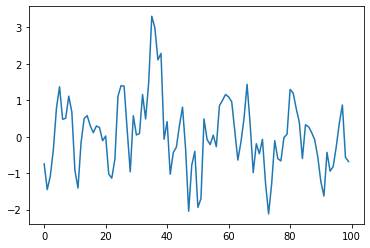





 28%|██▊       | 1401/5000 [17:45<49:13,  1.22it/s]



 28%|██▊       | 1402/5000 [17:45<48:10,  1.24it/s]



 28%|██▊       | 1403/5000 [17:46<46:52,  1.28it/s]



 28%|██▊       | 1404/5000 [17:47<46:35,  1.29it/s]



 28%|██▊       | 1405/5000 [17:48<46:09,  1.30it/s]



 28%|██▊       | 1406/5000 [17:48<45:32,  1.32it/s]



 28%|██▊       | 1407/5000 [17:49<45:40,  1.31it/s]



 28%|██▊       | 1408/5000 [17:50<45:08,  1.33it/s]



 28%|██▊       | 1409/5000 [17:51<45:23,  1.32it/s]



 28%|██▊       | 1410/5000 [17:51<45:14,  1.32it/s]



 28%|██▊       | 1411/5000 [17:52<44:50,  1.33it/s]



 28%|██▊       | 1412/5000 [17:53<45:06,  1.33it/s]



 28%|██▊       | 1413/5000 [17:54<44:43,  1.34it/s]



 28%|██▊       | 1414/5000 [17:54<44:58,  1.33it/s]



 28%|██▊       | 1415/5000 [17:55<45:02,  1.33it/s]



 28%|██▊       | 1416/5000 [17:56<44:42,  1.34it/s]



 28%|██▊       | 1417/5000 [17:57<45:04,  1.32it/s]



 28%|██▊       | 1418/5000 [17:57<44:44,  1.33it/s]



 28%|█

 30%|███       | 1523/5000 [19:16<43:08,  1.34it/s]



 30%|███       | 1524/5000 [19:16<43:05,  1.34it/s]



 30%|███       | 1525/5000 [19:17<43:00,  1.35it/s]



 31%|███       | 1526/5000 [19:18<42:34,  1.36it/s]



 31%|███       | 1527/5000 [19:19<42:49,  1.35it/s]



 31%|███       | 1528/5000 [19:19<42:27,  1.36it/s]



 31%|███       | 1529/5000 [19:20<42:33,  1.36it/s]



 31%|███       | 1530/5000 [19:21<42:36,  1.36it/s]



 31%|███       | 1531/5000 [19:22<42:16,  1.37it/s]



 31%|███       | 1532/5000 [19:22<42:30,  1.36it/s]



 31%|███       | 1533/5000 [19:23<42:10,  1.37it/s]



 31%|███       | 1534/5000 [19:24<42:25,  1.36it/s]



 31%|███       | 1535/5000 [19:24<42:25,  1.36it/s]



 31%|███       | 1536/5000 [19:25<42:12,  1.37it/s]



 31%|███       | 1537/5000 [19:26<42:33,  1.36it/s]



 31%|███       | 1538/5000 [19:27<42:17,  1.36it/s]



 31%|███       | 1539/5000 [19:27<42:31,  1.36it/s]



 31%|███       | 1540/5000 [19:28<42:41,  1.35it/s]



 31%|███  

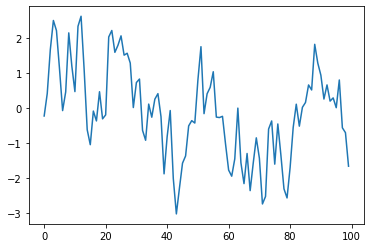

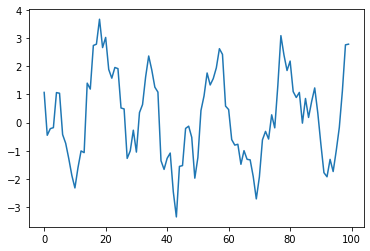





 32%|███▏      | 1601/5000 [20:14<47:22,  1.20it/s]



 32%|███▏      | 1602/5000 [20:15<46:26,  1.22it/s]



 32%|███▏      | 1603/5000 [20:16<45:10,  1.25it/s]



 32%|███▏      | 1604/5000 [20:17<44:46,  1.26it/s]



 32%|███▏      | 1605/5000 [20:17<44:23,  1.27it/s]



 32%|███▏      | 1606/5000 [20:18<43:44,  1.29it/s]



 32%|███▏      | 1607/5000 [20:19<43:49,  1.29it/s]



 32%|███▏      | 1608/5000 [20:20<43:22,  1.30it/s]



 32%|███▏      | 1609/5000 [20:20<43:30,  1.30it/s]



 32%|███▏      | 1610/5000 [20:21<43:28,  1.30it/s]



 32%|███▏      | 1611/5000 [20:22<43:05,  1.31it/s]



 32%|███▏      | 1612/5000 [20:23<43:18,  1.30it/s]



 32%|███▏      | 1613/5000 [20:23<42:49,  1.32it/s]



 32%|███▏      | 1614/5000 [20:24<43:00,  1.31it/s]



 32%|███▏      | 1615/5000 [20:25<42:40,  1.32it/s]



 32%|███▏      | 1616/5000 [20:26<42:03,  1.34it/s]



 32%|███▏      | 1617/5000 [20:26<42:07,  1.34it/s]



 32%|███▏      | 1618/5000 [20:27<41:43,  1.35it/s]



 32%|█

 34%|███▍      | 1723/5000 [21:46<39:53,  1.37it/s]



 34%|███▍      | 1724/5000 [21:46<40:06,  1.36it/s]



 34%|███▍      | 1725/5000 [21:47<40:15,  1.36it/s]



 35%|███▍      | 1726/5000 [21:48<39:58,  1.37it/s]



 35%|███▍      | 1727/5000 [21:49<40:14,  1.36it/s]



 35%|███▍      | 1728/5000 [21:49<40:01,  1.36it/s]



 35%|███▍      | 1729/5000 [21:50<40:16,  1.35it/s]



 35%|███▍      | 1730/5000 [21:51<40:19,  1.35it/s]



 35%|███▍      | 1731/5000 [21:52<39:56,  1.36it/s]



 35%|███▍      | 1732/5000 [21:52<40:13,  1.35it/s]



 35%|███▍      | 1733/5000 [21:53<39:57,  1.36it/s]



 35%|███▍      | 1734/5000 [21:54<40:16,  1.35it/s]



 35%|███▍      | 1735/5000 [21:55<40:37,  1.34it/s]



 35%|███▍      | 1736/5000 [21:55<40:26,  1.35it/s]



 35%|███▍      | 1737/5000 [21:56<40:52,  1.33it/s]



 35%|███▍      | 1738/5000 [21:57<40:43,  1.34it/s]



 35%|███▍      | 1739/5000 [21:58<40:59,  1.33it/s]



 35%|███▍      | 1740/5000 [21:58<41:11,  1.32it/s]



 35%|███▍ 

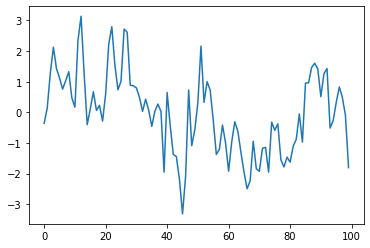

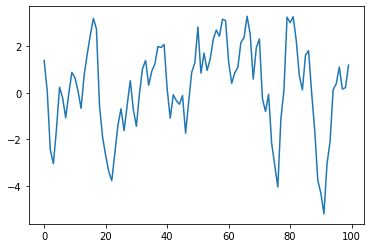





 36%|███▌      | 1801/5000 [22:45<43:56,  1.21it/s]



 36%|███▌      | 1802/5000 [22:46<43:04,  1.24it/s]



 36%|███▌      | 1803/5000 [22:46<42:04,  1.27it/s]



 36%|███▌      | 1804/5000 [22:47<41:49,  1.27it/s]



 36%|███▌      | 1805/5000 [22:48<41:30,  1.28it/s]



 36%|███▌      | 1806/5000 [22:49<40:35,  1.31it/s]



 36%|███▌      | 1807/5000 [22:49<40:24,  1.32it/s]



 36%|███▌      | 1808/5000 [22:50<39:46,  1.34it/s]



 36%|███▌      | 1809/5000 [22:51<39:50,  1.33it/s]



 36%|███▌      | 1810/5000 [22:52<39:44,  1.34it/s]



 36%|███▌      | 1811/5000 [22:52<39:22,  1.35it/s]



 36%|███▌      | 1812/5000 [22:53<39:33,  1.34it/s]



 36%|███▋      | 1813/5000 [22:54<39:15,  1.35it/s]



 36%|███▋      | 1814/5000 [22:55<39:27,  1.35it/s]



 36%|███▋      | 1815/5000 [22:55<39:25,  1.35it/s]



 36%|███▋      | 1816/5000 [22:56<39:05,  1.36it/s]



 36%|███▋      | 1817/5000 [22:57<39:22,  1.35it/s]



 36%|███▋      | 1818/5000 [22:57<39:01,  1.36it/s]



 36%|█

 38%|███▊      | 1923/5000 [24:16<37:36,  1.36it/s]



 38%|███▊      | 1924/5000 [24:17<37:49,  1.36it/s]



 38%|███▊      | 1925/5000 [24:18<38:07,  1.34it/s]



 39%|███▊      | 1926/5000 [24:18<38:01,  1.35it/s]



 39%|███▊      | 1927/5000 [24:19<38:23,  1.33it/s]



 39%|███▊      | 1928/5000 [24:20<38:09,  1.34it/s]



 39%|███▊      | 1929/5000 [24:21<38:32,  1.33it/s]



 39%|███▊      | 1930/5000 [24:21<38:39,  1.32it/s]



 39%|███▊      | 1931/5000 [24:22<38:20,  1.33it/s]



 39%|███▊      | 1932/5000 [24:23<38:36,  1.32it/s]



 39%|███▊      | 1933/5000 [24:24<38:17,  1.34it/s]



 39%|███▊      | 1934/5000 [24:24<38:31,  1.33it/s]



 39%|███▊      | 1935/5000 [24:25<38:37,  1.32it/s]



 39%|███▊      | 1936/5000 [24:26<38:19,  1.33it/s]



 39%|███▊      | 1937/5000 [24:27<38:37,  1.32it/s]



 39%|███▉      | 1938/5000 [24:28<38:23,  1.33it/s]



 39%|███▉      | 1939/5000 [24:28<38:34,  1.32it/s]



 39%|███▉      | 1940/5000 [24:29<38:46,  1.32it/s]



 39%|███▉ 

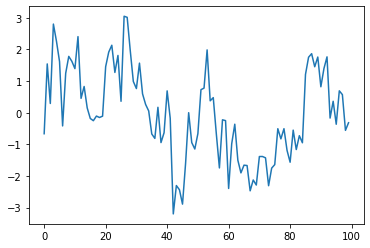

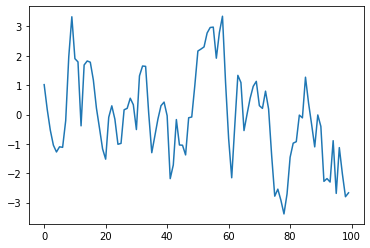





 40%|████      | 2001/5000 [25:15<39:56,  1.25it/s]



 40%|████      | 2002/5000 [25:16<39:05,  1.28it/s]



 40%|████      | 2003/5000 [25:17<38:07,  1.31it/s]



 40%|████      | 2004/5000 [25:17<37:50,  1.32it/s]



 40%|████      | 2005/5000 [25:18<37:31,  1.33it/s]



 40%|████      | 2006/5000 [25:19<36:59,  1.35it/s]



 40%|████      | 2007/5000 [25:20<37:02,  1.35it/s]



 40%|████      | 2008/5000 [25:20<36:43,  1.36it/s]



 40%|████      | 2009/5000 [25:21<36:48,  1.35it/s]



 40%|████      | 2010/5000 [25:22<36:47,  1.35it/s]



 40%|████      | 2011/5000 [25:22<36:27,  1.37it/s]



 40%|████      | 2012/5000 [25:23<36:41,  1.36it/s]



 40%|████      | 2013/5000 [25:24<36:21,  1.37it/s]



 40%|████      | 2014/5000 [25:25<36:32,  1.36it/s]



 40%|████      | 2015/5000 [25:25<36:37,  1.36it/s]



 40%|████      | 2016/5000 [25:26<36:18,  1.37it/s]



 40%|████      | 2017/5000 [25:27<36:34,  1.36it/s]



 40%|████      | 2018/5000 [25:28<36:18,  1.37it/s]



 40%|█

 42%|████▏     | 2123/5000 [26:46<36:19,  1.32it/s]



 42%|████▏     | 2124/5000 [26:47<36:34,  1.31it/s]



 42%|████▎     | 2125/5000 [26:48<36:34,  1.31it/s]



 43%|████▎     | 2126/5000 [26:49<36:13,  1.32it/s]



 43%|████▎     | 2127/5000 [26:49<36:31,  1.31it/s]



 43%|████▎     | 2128/5000 [26:50<36:14,  1.32it/s]



 43%|████▎     | 2129/5000 [26:51<36:34,  1.31it/s]



 43%|████▎     | 2130/5000 [26:52<36:36,  1.31it/s]



 43%|████▎     | 2131/5000 [26:52<36:16,  1.32it/s]



 43%|████▎     | 2132/5000 [26:53<36:30,  1.31it/s]



 43%|████▎     | 2133/5000 [26:54<36:11,  1.32it/s]



 43%|████▎     | 2134/5000 [26:55<36:25,  1.31it/s]



 43%|████▎     | 2135/5000 [26:55<36:28,  1.31it/s]



 43%|████▎     | 2136/5000 [26:56<36:10,  1.32it/s]



 43%|████▎     | 2137/5000 [26:57<36:24,  1.31it/s]



 43%|████▎     | 2138/5000 [26:58<36:09,  1.32it/s]



 43%|████▎     | 2139/5000 [26:58<36:19,  1.31it/s]



 43%|████▎     | 2140/5000 [26:59<36:21,  1.31it/s]



 43%|████▎

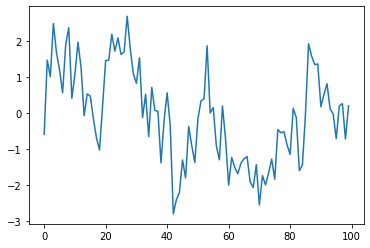

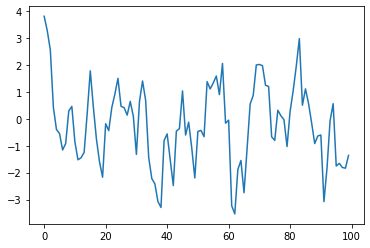





 44%|████▍     | 2201/5000 [27:45<38:18,  1.22it/s]



 44%|████▍     | 2202/5000 [27:46<37:35,  1.24it/s]



 44%|████▍     | 2203/5000 [27:47<36:42,  1.27it/s]



 44%|████▍     | 2204/5000 [27:47<36:29,  1.28it/s]



 44%|████▍     | 2205/5000 [27:48<36:14,  1.29it/s]



 44%|████▍     | 2206/5000 [27:49<35:42,  1.30it/s]



 44%|████▍     | 2207/5000 [27:50<35:45,  1.30it/s]



 44%|████▍     | 2208/5000 [27:50<35:24,  1.31it/s]



 44%|████▍     | 2209/5000 [27:51<35:34,  1.31it/s]



 44%|████▍     | 2210/5000 [27:52<35:29,  1.31it/s]



 44%|████▍     | 2211/5000 [27:53<35:08,  1.32it/s]



 44%|████▍     | 2212/5000 [27:54<35:18,  1.32it/s]



 44%|████▍     | 2213/5000 [27:54<35:03,  1.32it/s]



 44%|████▍     | 2214/5000 [27:55<35:17,  1.32it/s]



 44%|████▍     | 2215/5000 [27:56<35:19,  1.31it/s]



 44%|████▍     | 2216/5000 [27:57<35:01,  1.33it/s]



 44%|████▍     | 2217/5000 [27:57<35:14,  1.32it/s]



 44%|████▍     | 2218/5000 [27:58<34:56,  1.33it/s]



 44%|█

 46%|████▋     | 2323/5000 [29:17<33:40,  1.33it/s]



 46%|████▋     | 2324/5000 [29:18<33:53,  1.32it/s]



 46%|████▋     | 2325/5000 [29:18<33:55,  1.31it/s]



 47%|████▋     | 2326/5000 [29:19<33:38,  1.32it/s]



 47%|████▋     | 2327/5000 [29:20<33:53,  1.31it/s]



 47%|████▋     | 2328/5000 [29:21<33:36,  1.33it/s]



 47%|████▋     | 2329/5000 [29:21<33:47,  1.32it/s]



 47%|████▋     | 2330/5000 [29:22<33:50,  1.32it/s]



 47%|████▋     | 2331/5000 [29:23<33:36,  1.32it/s]



 47%|████▋     | 2332/5000 [29:24<33:48,  1.32it/s]



 47%|████▋     | 2333/5000 [29:24<33:29,  1.33it/s]



 47%|████▋     | 2334/5000 [29:25<33:39,  1.32it/s]



 47%|████▋     | 2335/5000 [29:26<33:44,  1.32it/s]



 47%|████▋     | 2336/5000 [29:27<33:31,  1.32it/s]



 47%|████▋     | 2337/5000 [29:27<33:44,  1.32it/s]



 47%|████▋     | 2338/5000 [29:28<33:43,  1.32it/s]



 47%|████▋     | 2339/5000 [29:29<33:58,  1.31it/s]



 47%|████▋     | 2340/5000 [29:30<33:50,  1.31it/s]



 47%|████▋

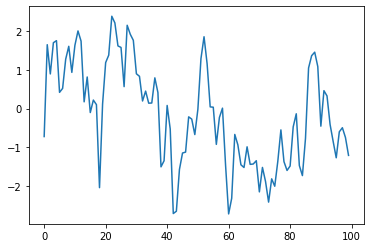

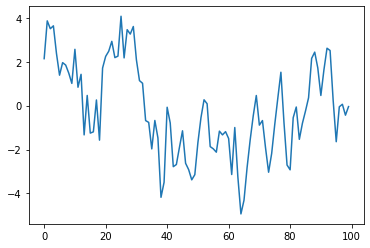





 48%|████▊     | 2401/5000 [30:16<35:56,  1.21it/s]



 48%|████▊     | 2402/5000 [30:16<35:10,  1.23it/s]



 48%|████▊     | 2403/5000 [30:17<34:15,  1.26it/s]



 48%|████▊     | 2404/5000 [30:18<34:01,  1.27it/s]



 48%|████▊     | 2405/5000 [30:19<33:42,  1.28it/s]



 48%|████▊     | 2406/5000 [30:19<33:12,  1.30it/s]



 48%|████▊     | 2407/5000 [30:20<33:16,  1.30it/s]



 48%|████▊     | 2408/5000 [30:21<32:57,  1.31it/s]



 48%|████▊     | 2409/5000 [30:22<33:05,  1.30it/s]



 48%|████▊     | 2410/5000 [30:22<33:03,  1.31it/s]



 48%|████▊     | 2411/5000 [30:23<32:45,  1.32it/s]



 48%|████▊     | 2412/5000 [30:24<32:54,  1.31it/s]



 48%|████▊     | 2413/5000 [30:25<32:36,  1.32it/s]



 48%|████▊     | 2414/5000 [30:26<32:50,  1.31it/s]



 48%|████▊     | 2415/5000 [30:26<32:49,  1.31it/s]



 48%|████▊     | 2416/5000 [30:27<32:35,  1.32it/s]



 48%|████▊     | 2417/5000 [30:28<32:48,  1.31it/s]



 48%|████▊     | 2418/5000 [30:29<32:34,  1.32it/s]



 48%|█

 50%|█████     | 2523/5000 [31:48<30:33,  1.35it/s]



 50%|█████     | 2524/5000 [31:48<30:42,  1.34it/s]



 50%|█████     | 2525/5000 [31:49<30:41,  1.34it/s]



 51%|█████     | 2526/5000 [31:50<30:27,  1.35it/s]



 51%|█████     | 2527/5000 [31:51<30:40,  1.34it/s]



 51%|█████     | 2528/5000 [31:51<30:24,  1.36it/s]



 51%|█████     | 2529/5000 [31:52<30:36,  1.35it/s]



 51%|█████     | 2530/5000 [31:53<30:38,  1.34it/s]



 51%|█████     | 2531/5000 [31:54<30:22,  1.36it/s]



 51%|█████     | 2532/5000 [31:54<30:35,  1.34it/s]



 51%|█████     | 2533/5000 [31:55<30:20,  1.36it/s]



 51%|█████     | 2534/5000 [31:56<30:33,  1.34it/s]



 51%|█████     | 2535/5000 [31:57<30:34,  1.34it/s]



 51%|█████     | 2536/5000 [31:57<30:19,  1.35it/s]



 51%|█████     | 2537/5000 [31:58<30:28,  1.35it/s]



 51%|█████     | 2538/5000 [31:59<30:15,  1.36it/s]



 51%|█████     | 2539/5000 [32:00<30:27,  1.35it/s]



 51%|█████     | 2540/5000 [32:00<30:26,  1.35it/s]



 51%|█████

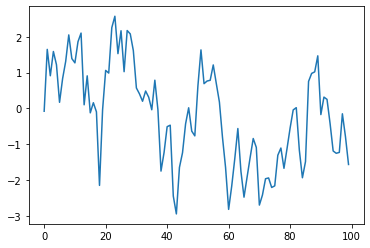

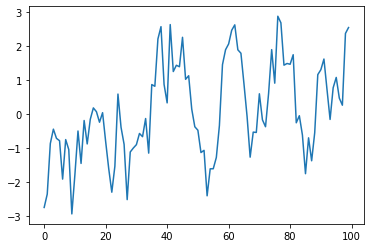





 52%|█████▏    | 2601/5000 [32:47<32:48,  1.22it/s]



 52%|█████▏    | 2602/5000 [32:48<31:59,  1.25it/s]



 52%|█████▏    | 2603/5000 [32:48<31:04,  1.29it/s]



 52%|█████▏    | 2604/5000 [32:49<30:44,  1.30it/s]



 52%|█████▏    | 2605/5000 [32:50<30:26,  1.31it/s]



 52%|█████▏    | 2606/5000 [32:51<29:59,  1.33it/s]



 52%|█████▏    | 2607/5000 [32:51<30:00,  1.33it/s]



 52%|█████▏    | 2608/5000 [32:52<29:40,  1.34it/s]



 52%|█████▏    | 2609/5000 [32:53<29:46,  1.34it/s]



 52%|█████▏    | 2610/5000 [32:54<29:43,  1.34it/s]



 52%|█████▏    | 2611/5000 [32:54<29:27,  1.35it/s]



 52%|█████▏    | 2612/5000 [32:55<30:05,  1.32it/s]



 52%|█████▏    | 2613/5000 [32:56<29:43,  1.34it/s]



 52%|█████▏    | 2614/5000 [32:57<29:46,  1.34it/s]



 52%|█████▏    | 2615/5000 [32:57<29:42,  1.34it/s]



 52%|█████▏    | 2616/5000 [32:58<29:31,  1.35it/s]



 52%|█████▏    | 2617/5000 [32:59<29:38,  1.34it/s]



 52%|█████▏    | 2618/5000 [32:59<29:25,  1.35it/s]



 52%|█

 54%|█████▍    | 2723/5000 [34:18<28:30,  1.33it/s]



 54%|█████▍    | 2724/5000 [34:19<28:44,  1.32it/s]



 55%|█████▍    | 2725/5000 [34:20<28:48,  1.32it/s]



 55%|█████▍    | 2726/5000 [34:21<28:32,  1.33it/s]



 55%|█████▍    | 2727/5000 [34:21<28:44,  1.32it/s]



 55%|█████▍    | 2728/5000 [34:22<28:32,  1.33it/s]



 55%|█████▍    | 2729/5000 [34:23<28:45,  1.32it/s]



 55%|█████▍    | 2730/5000 [34:24<28:45,  1.32it/s]



 55%|█████▍    | 2731/5000 [34:24<28:30,  1.33it/s]



 55%|█████▍    | 2732/5000 [34:25<28:42,  1.32it/s]



 55%|█████▍    | 2733/5000 [34:26<28:28,  1.33it/s]



 55%|█████▍    | 2734/5000 [34:27<28:40,  1.32it/s]



 55%|█████▍    | 2735/5000 [34:27<28:42,  1.31it/s]



 55%|█████▍    | 2736/5000 [34:28<28:27,  1.33it/s]



 55%|█████▍    | 2737/5000 [34:29<28:37,  1.32it/s]



 55%|█████▍    | 2738/5000 [34:30<28:24,  1.33it/s]



 55%|█████▍    | 2739/5000 [34:30<28:37,  1.32it/s]



 55%|█████▍    | 2740/5000 [34:31<28:37,  1.32it/s]



 55%|█████

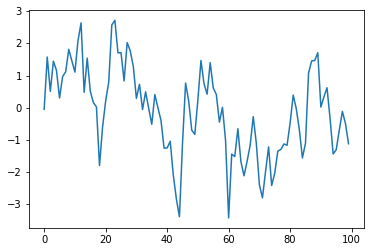

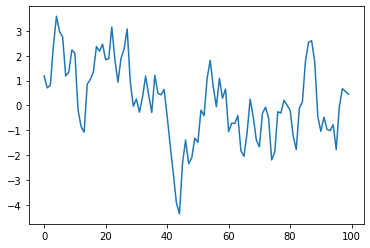





 56%|█████▌    | 2801/5000 [35:17<29:37,  1.24it/s]



 56%|█████▌    | 2802/5000 [35:18<28:59,  1.26it/s]



 56%|█████▌    | 2803/5000 [35:19<28:18,  1.29it/s]



 56%|█████▌    | 2804/5000 [35:19<28:05,  1.30it/s]



 56%|█████▌    | 2805/5000 [35:20<27:49,  1.31it/s]



 56%|█████▌    | 2806/5000 [35:21<27:25,  1.33it/s]



 56%|█████▌    | 2807/5000 [35:22<27:28,  1.33it/s]



 56%|█████▌    | 2808/5000 [35:22<27:08,  1.35it/s]



 56%|█████▌    | 2809/5000 [35:23<27:15,  1.34it/s]



 56%|█████▌    | 2810/5000 [35:24<27:25,  1.33it/s]



 56%|█████▌    | 2811/5000 [35:25<27:18,  1.34it/s]



 56%|█████▌    | 2812/5000 [35:25<27:36,  1.32it/s]



 56%|█████▋    | 2813/5000 [35:26<27:26,  1.33it/s]



 56%|█████▋    | 2814/5000 [35:27<27:37,  1.32it/s]



 56%|█████▋    | 2815/5000 [35:28<27:44,  1.31it/s]



 56%|█████▋    | 2816/5000 [35:28<27:31,  1.32it/s]



 56%|█████▋    | 2817/5000 [35:29<27:43,  1.31it/s]



 56%|█████▋    | 2818/5000 [35:30<27:30,  1.32it/s]



 56%|█

 58%|█████▊    | 2923/5000 [36:49<26:16,  1.32it/s]



 58%|█████▊    | 2924/5000 [36:50<26:27,  1.31it/s]



 58%|█████▊    | 2925/5000 [36:51<26:28,  1.31it/s]



 59%|█████▊    | 2926/5000 [36:52<26:14,  1.32it/s]



 59%|█████▊    | 2927/5000 [36:52<26:23,  1.31it/s]



 59%|█████▊    | 2928/5000 [36:53<26:12,  1.32it/s]



 59%|█████▊    | 2929/5000 [36:54<26:21,  1.31it/s]



 59%|█████▊    | 2930/5000 [36:55<26:24,  1.31it/s]



 59%|█████▊    | 2931/5000 [36:55<26:13,  1.32it/s]



 59%|█████▊    | 2932/5000 [36:56<26:23,  1.31it/s]



 59%|█████▊    | 2933/5000 [36:57<26:08,  1.32it/s]



 59%|█████▊    | 2934/5000 [36:58<26:16,  1.31it/s]



 59%|█████▊    | 2935/5000 [36:58<26:16,  1.31it/s]



 59%|█████▊    | 2936/5000 [36:59<26:03,  1.32it/s]



 59%|█████▊    | 2937/5000 [37:00<26:14,  1.31it/s]



 59%|█████▉    | 2938/5000 [37:01<26:01,  1.32it/s]



 59%|█████▉    | 2939/5000 [37:01<26:11,  1.31it/s]



 59%|█████▉    | 2940/5000 [37:02<26:10,  1.31it/s]



 59%|█████

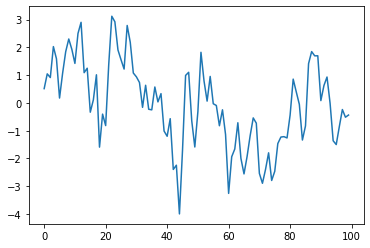

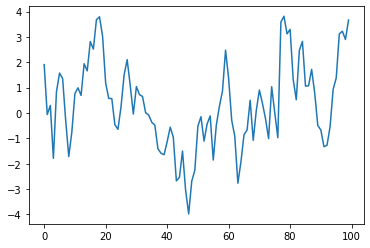





 60%|██████    | 3001/5000 [37:49<28:00,  1.19it/s]



 60%|██████    | 3002/5000 [37:50<27:20,  1.22it/s]



 60%|██████    | 3003/5000 [37:50<26:34,  1.25it/s]



 60%|██████    | 3004/5000 [37:51<26:26,  1.26it/s]



 60%|██████    | 3005/5000 [37:52<26:11,  1.27it/s]



 60%|██████    | 3006/5000 [37:53<25:46,  1.29it/s]



 60%|██████    | 3007/5000 [37:53<25:48,  1.29it/s]



 60%|██████    | 3008/5000 [37:54<25:29,  1.30it/s]



 60%|██████    | 3009/5000 [37:55<25:34,  1.30it/s]



 60%|██████    | 3010/5000 [37:56<25:32,  1.30it/s]



 60%|██████    | 3011/5000 [37:56<25:21,  1.31it/s]



 60%|██████    | 3012/5000 [37:57<25:30,  1.30it/s]



 60%|██████    | 3013/5000 [37:58<25:18,  1.31it/s]



 60%|██████    | 3014/5000 [37:59<25:27,  1.30it/s]



 60%|██████    | 3015/5000 [38:00<25:28,  1.30it/s]



 60%|██████    | 3016/5000 [38:00<25:12,  1.31it/s]



 60%|██████    | 3017/5000 [38:01<25:23,  1.30it/s]



 60%|██████    | 3018/5000 [38:02<25:08,  1.31it/s]



 60%|█

 62%|██████▏   | 3123/5000 [39:21<23:47,  1.31it/s]



 62%|██████▏   | 3124/5000 [39:22<23:56,  1.31it/s]



 62%|██████▎   | 3125/5000 [39:23<23:55,  1.31it/s]

In [ ]:
run_GAN()